# Приоритезация гипотез и анализ А/В теста

**Описание и цель проекта:**

У крупного интернет-магазина есть список гипотез для увеличения выручки. Наша задача заключается в том, чтобы выбрать наиболее важные гипотезы, запустить A/B-тест и проанализировать результаты.

В нашем распоряжении 3 датасета:

**hypothesis**
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**orders**
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

**visitors**
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

**Этапы исследования:**
1) Обзор данных и подготовка к анализу\
2) Приоритизация гипотез\
3) Анализ A/B-теста

## Обзор данных и подготовка к анализу

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import stats as st
from datetime import date, datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Сохраним данные из файлов
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
# Рассмотрим таблицу hypothesis
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 1)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
# Переименуем столбцы - приведем наименование к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()

In [6]:
# Рассмотрим таблицу orders
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
# Переименуем столбцы transactionId и visitorId
orders = orders.rename(columns={'transactionId':'transaction_id','visitorId':'visitor_id'})
# Приведем дату к нужному формату
orders['date'] = pd.to_datetime(orders['date'], format = '%Y-%m-%d %H:%M:%S')
# Проверим на явные дубликаты 
orders.duplicated().sum()

0

In [9]:
# Посмотрим на распределение пользователей
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

В таблице orders в группах неравное количество участников.

In [10]:
# Проверим не попадают ли у нас пользователи одновременно в группу А и В
orders_group_A = orders.query('group == "A"')['visitor_id']
orders_group_B = orders.query('group == "B"')['visitor_id']

In [11]:
# С помощью цикла проверим пересечения id пользователей
def intersection_list(list1, list2): 
   list3 = [value for value in list1 if value in list2] 
   return list3 

In [12]:
display(intersection_list(orders_group_A, orders_group_B)) 

[]

Пересечений id не найдено, значит группы А и В независимы, можно использовать данные для анализа.

In [13]:
# Определим минимальную и максимальную дату заказа
orders.agg({'date': ['min', 'max']})

,date
min,2019-08-01
max,2019-08-31


 Данные представлены за Август 2019 года.

In [14]:
# Рассмотрим таблицу visitors
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [15]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [16]:
# Приведем дату к нужному формату
visitors['date'] = pd.to_datetime(visitors['date'], format = '%Y-%m-%d %H:%M:%S')
# Проверим на явные дубликаты 
visitors.duplicated().sum()

0

In [17]:
# Посмотрим на распределение 
visitors_sum = visitors.groupby('group')['visitors'].sum()
visitors_sum

group
A    18736
B    18916
Name: visitors, dtype: int64

In [18]:
visitors['group'].value_counts()

B    31
A    31
Name: group, dtype: int64

К сожалению, по таблице visitors мы не сможем проверить корректность распределения пользователей по группам А и В, так как у нас нет данных visitor_id. Данной проверкой мы убедились лишь в том, что количество дней теста у групп А и В совпадает и суммарное количество пользователей за месяц у группы В чуть больше чем у группы А.

In [19]:
# Определим минимальную и максимальную дату в таблице visitors
visitors.agg({'date': ['min', 'max']})

,date
min,2019-08-01
max,2019-08-31


Данные в таблице visitors, как и в таблице orders, представлены за Август 2019 года.

**Вывод:**
    
На первом этапе мы провели обзор данных, скорректировали наименования столбцов, привели дату к нужному формату и проверили, что в данных нет дубликатов и пропусков. Также мы проверили, что группы сформированы только по уникальным пользователям и между ними нет пересечений. 

## Приоритизация гипотез

В файле `hypothesis` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Для приоритезации гипотез мы будем использовать одни из самых распространенных методов - `ICE` и `RICE`.

### Применим метод ICE для приоритизации гипотез

In [20]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'])
hypothesis.sort_values(by ='ICE',ascending = False).round(2)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


По методу ICE наиболее перспективными являются следующие гипотезы:
1) Гипотеза №9: Запустить акцию, дающую скидку на товар в день рождения\
2) Гипотеза №1: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей\
3) Гипотеза №8: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

### Применим метод RICE для приоритизации гипотез

In [21]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values(by ='RICE',ascending = False).round(2)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


По методу RICE приоритет гипотез немного изменился, наиболее перспективными являются:

1) Гипотеза №8: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок\
2) Гипотеза №3: Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа\
3) На третьем месте 2 гипотезы:
 - Гипотеза №1: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
 - Гипотеза №7: Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

Гипотеза №9, занимающая 1-е место по методу ICE, по методу RICE занимает лишь 5-е место

### Изменение приоритизации гипотез при применении RICE вместо ICE

Метод `RICE` в отличии от `ICE` учитывает ещё один дополнительный параметр - Reach(охват), который оценивает скольких пользователей затронет изменение, которое мы хотим внести. 

В данном случае у гипотезы №9 этот параметр очень низкий, поэтому она не попала в тройку лидеров по `RICE`. В тоже время, гипотезы, у которых показатели impact и confidence не самые высокие за счёт значительного параметра reach вышли вперед.

In [22]:
# Выведем сводную таблицу приоритетов по 2-м методам
priority_table = pd.DataFrame({'ICE': [8, 0, 7, 6, 2, 1, 5, 3, 4], 'RICE': [7, 2, 0, 6, 8, 3, 1, 5, 4]})
priority_table

,ICE,RICE
0,8,7
1,0,2
2,7,0
3,6,6
4,2,8
5,1,3
6,5,1
7,3,5
8,4,4


**Вывод**

В связи с тем, что есть несколько подходов к определению приоритетности гипотез, которые учитывают разные параметры, результаты по ним тоже отличаются. На данном этапе мы использовали одни из популярных методов - `ICE` и `RICE`, которые отличаются между собой наличием параметра охвата.

По результатам анализа считаю, что в первую очередь можно точно исследовать гипотезы №8 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок) и №1 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей), которые попали в топ-3 по двум способам приоритезации. Или же взять топ-3 гипотез по методу `RICE`, так как он учитывает больше параметров.

## Анализ A/B-теста

Результаты A/B-тест описаны в файлах orders и visitors. Проанализируем A/B-тест.

### Построим график кумулятивной выручки по группам

In [23]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
    'date' : 'max', 
    'group' : 'max', 
    'transaction_id' : pd.Series.nunique, 
    'visitor_id' : pd.Series.nunique, 
    'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
    'date' : 'max', 
    'group' : 'max', 
    'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам новые названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


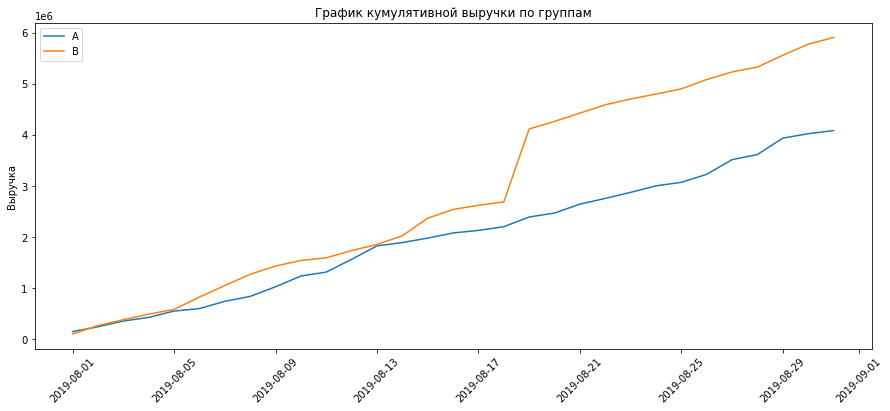

In [24]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.rcParams["figure.figsize"] = (15,6)

# Строим график выручки группы А
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')

plt.xticks(rotation=45)
plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.ylabel('Выручка');


Выручки почти равномерно увеличивались в течение всего теста. Показатели по группе В практически всегда лучше, при этом в середине августа наблюдается значительный всплеск по группе В, что может свидетельствовать об увеличении количества заказов или о появлении очень дорогих заказов.

### Построим график кумулятивного среднего чека по группам

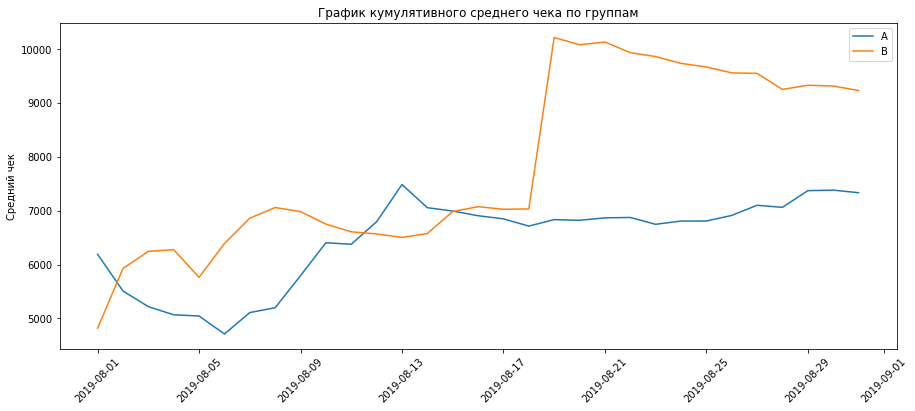

In [25]:
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B')

plt.xticks(rotation=45)
plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Средний чек');

На графике видно, что кумулятивные значения среднего чека достаточно нестабильны, у обеих групп есть значительные всплески в данных. На данном этапе рано принимать решения по данной метрике, требуется анализ выбросов.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

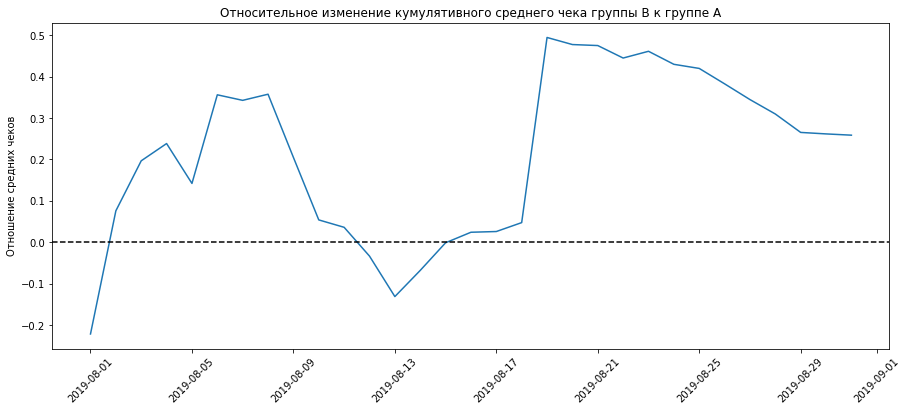

In [26]:
# собираем данные в одном датафрейме
merged_cumulative_revenue= cumulative_revenue_A.merge(cumulative_revenue_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.ylabel('Отношение средних чеков');

В нескольких точках график различия между сегментами резко «скачет». Вероятно, именно в эти дни были соверешены большие заказы.

### Построим график кумулятивной конверсии по группам

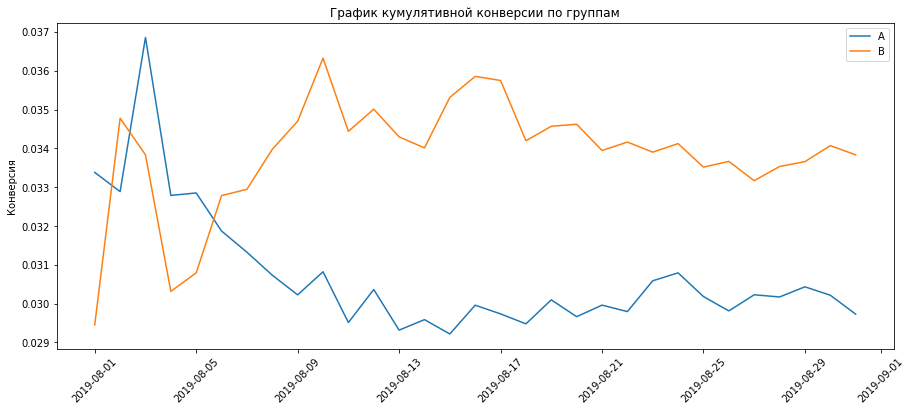

In [27]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')

plt.xticks(rotation=45)
plt.legend()
plt.title('График кумулятивной конверсии по группам')
plt.ylabel('Конверсия');

В начале периода по двум группам наблюдаются резкие скачки. Далее по группе А конверсия резко снижается и фиксируется в районе 0,03. По группе В в районе 9 августа наблюдается второй резкий скачек, далее показатель конверсии стабилизируется в районе 0,034.

### Построим график относительного изменения кумулятивной конверсии группы B к группе A

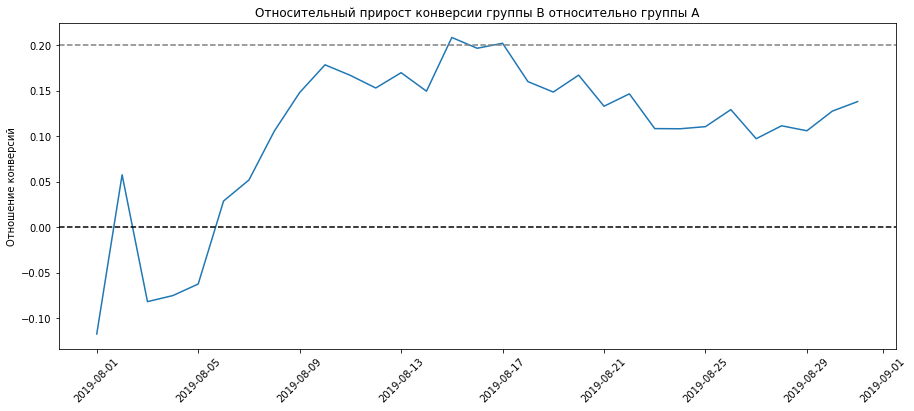

In [28]:
merged_сumulative_сonversions = cumulative_data_A[['date','conversion']].merge(cumulative_data_B[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(merged_сumulative_сonversions['date'], merged_сumulative_сonversions['conversionB']/merged_сumulative_сonversions['conversionA']-1)

plt.xticks(rotation=45)
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.ylabel('Отношение конверсий')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--');

Конверсия группы В показывает себя намного лучше, достигая прироста до 20% относительно группы А.

### Построим точечный график количества заказов по пользователям

In [29]:
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [30]:
# найдем число заказов по пользователям
orders_by_users = orders.groupby('visitor_id').agg({'transaction_id':'nunique'}).rename(columns={'transaction_id':'orders'})
orders_by_users.head()

,orders
visitor_id,
5114589,1
6958315,1
8300375,2
11685486,1
39475350,1


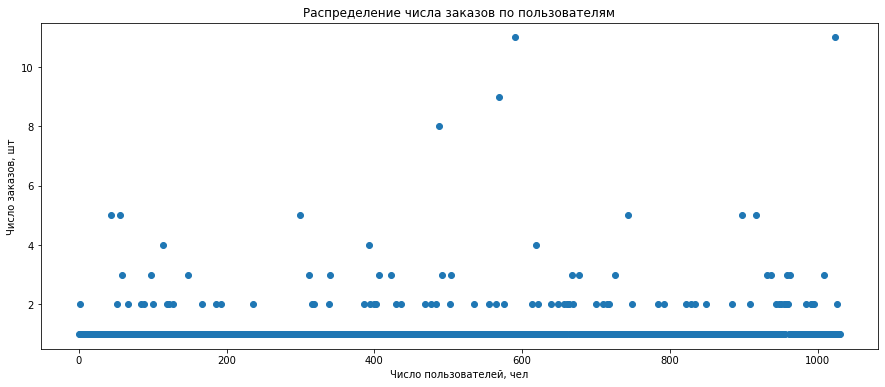

In [31]:
x_values = pd.Series(range(0,len(orders_by_users['orders'])))
plt.scatter(x_values, orders_by_users['orders'])

plt.title('Распределение числа заказов по пользователям')
plt.xlabel('Число пользователей, чел')
plt.ylabel('Число заказов, шт')
plt.show()

Основная часть пользователей совершает не более 2-х покупок, но также на графике мы видим часть данных, которые выбиваются из общей массы - аномальные значения. 

### Рассчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей

In [32]:
print(np.percentile(orders_by_users['orders'], [95, 99])) 

[2. 4.]


Не более 5% пользователей совершали больше двух заказов, и не более 1% пользователей - больше четырех заказов.

### Построим точечный график стоимостей заказов

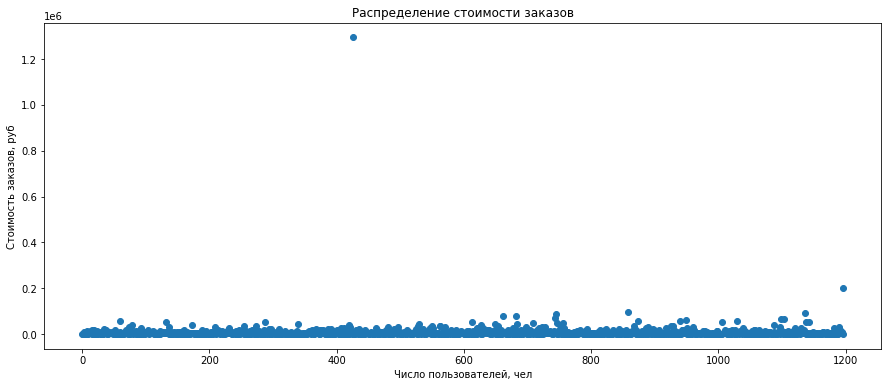

In [33]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x_values, orders['revenue']) 

plt.title('Распределение стоимости заказов')
plt.xlabel('Число пользователей, чел')
plt.ylabel('Стоимость заказов, руб')

plt.show()

На графике отчетливо видно 2 выброса.

### Рассчитаем 95-й и 99-й перцентили стоимости заказов

In [34]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5% заказов с чеком выше 28 тыс руб., и не более, чем 1% заказов с чеком больше 58,23 тыс.руб.

### Рассчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

Начнём с подготовки данных.

In [35]:
# получим агрегированные кумулятивные данные по дням о посетителях группы А
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_rer_date_A']

visitors_A_cummulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_rer_date_A': 'sum'}
    ),
    axis=1,
)
visitors_A_cummulative.columns = ['date', 'visitors_cummulative_A']

# получим агрегированные кумулятивные данные по дням о посетителях группы B
visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_rer_date_B']

visitors_B_cummulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_rer_date_B': 'sum'}
    ),
    axis=1,
)
visitors_B_cummulative.columns = ['date', 'visitors_cummulative_B']

# получаем агрегированные данные по дням о заказах и выручке группы А
orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

# получаем кумулятивные данные по дням о заказах и выручке группы А
orders_A_сummulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_A_сummulative.columns = [
    'date',
    'orders_сummulative_A',
    'revenue_сummulative_A',
]

# получаем агрегированные данные по дням о заказах и выручке группы B
orders_B_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

# получаем кумулятивные данные по дням о заказах и выручке группы B
orders_B_сummulative = orders_B_daily.apply(
    lambda x: orders_B_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_B_сummulative.columns = [
    'date',
    'orders_сummulative_B',
    'revenue_сummulative_B',
]

# Объединяем все данные в один датасет
data = (
    orders_A_daily.merge(
        orders_B_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_A_сummulative, left_on='date', right_on='date', how='left')
    .merge(orders_B_сummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cummulative, left_on='date', right_on='date', how='left')
)

data.head(5)


,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_сummulative_A,revenue_сummulative_A,orders_сummulative_B,revenue_сummulative_B,visitors_rer_date_A,visitors_rer_date_B,visitors_cummulative_A,visitors_cummulative_B
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Создадим переменные `orders_by_users_A` и `orders_by_users_B`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [36]:
orders_by_users_A = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_A.columns = ['user_id', 'orders']

orders_by_users_B = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_B.columns = ['user_id', 'orders']

Объявим переменные `sample_A` и `sample_B`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. 

In [37]:
sample_A = pd.concat(
    [
        orders_by_users_A['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_rer_date_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B = pd.concat(
    [
        orders_by_users_B['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_rer_date_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Сформулируем гипотезы:

- Н0: различия в конверсиях между группами по «сырым» данным статистически не значимы
- Н1: различия в конверсиях между группами по «сырым» данным статистически значимы

Зададим уровень статистической значимости - 5%

In [39]:
print("{0:.3f}".format(stats.mannwhitneyu(sample_A, sample_B)[1]))
print("{0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

0.017
0.138


Первое число — p-value = 0,017 меньше 0,05. Значит, нулевую гипотезу о том, что различия в конверсиях между группами статистически не значимы мы отвергаем. Относительный прирост конверсии группы B к конверсии группы А - 13%.

### Рассчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы:

- Н0: различия в среднем чеке заказа между группами по «сырым» данным статистически не значимы
- Н1: различия в среднем чеке заказа между группами по «сырым» данным статистически значимы

Уровень статистической значимости без изменений - 5%

In [40]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.729
0.259


P-value = 0,729 больше 0,05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Относительное различие среднего чека между группами - 26%, но не смотря на это мы не можем говорить о статистически значимой разнице.

### Рассчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным

1) 95-й и 99-й перцентили стоимости заказов равны 28 000 и 58 233.2 руб. \
2) 95-й и 99-й перцентили количества заказов на пользователя равны 2 и 4 шт.

Примем за аномальные значения 4 заказа более 28 тыс. руб. Узнаем, сколько всего аномальных пользователей:

In [41]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > 4]['user_id'],
        orders_by_users_B[orders_by_users_B['orders'] > 4]['user_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > 28000]['visitor_id']
ab_normal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(ab_normal_users.head(5))
print(ab_normal_users.shape[0]) 

1099    148427295
928     204675465
684     358944393
648     382846391
1189    393266494
dtype: int64
59


Всего 59 аномальных пользователя.

Сформулируем гипотезы:

- Н0: различия в конверсии между группами по «очищенным» данным статистически не значимы
- Н1: различия в конверсии между группами по «очищенным» данным статистически значимы

Уровень статистической значимости - 5%

In [42]:
sample_A_filtered = pd.concat(
    [
        orders_by_users_A[
            np.logical_not(orders_by_users_A['user_id'].isin(ab_normal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_rer_date_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B_filtered = pd.concat(
    [
        orders_by_users_B[
            np.logical_not(orders_by_users_B['user_id'].isin(ab_normal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_rer_date_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

print('{0:.3f}'.format(stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
print('{0:.3f}'.format(sample_B_filtered.mean()/sample_A_filtered.mean()-1)) 

0.018
0.145


Результаты теста по "очищенным" данным аналогичны результатам теста по сырым данным: значение p-value меньше 0,05 - отвергаем нулевую гипотезу. Конверсия по группе В лучше, чем конверсия по группе А.

### Рассчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [43]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(ab_normal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(ab_normal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(ab_normal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(ab_normal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.961
-0.014


P-value = 0,961 больше 0,05 - значит нулевую гипотезу не отвергаем, а вот относительное различие среднего чека между группами после очистки изменилось -0,014, что свидетельствует о том, что средний чек группы А всё-таки незначительно выше, чем у группы В.

### Решение по результатам теста

По результатам теста можно сделать следующие выводы: 

- была обнаружена статистически значимая разница между двумя группами по показателю конверсии, группа В превосходит группу А как по "сырым" данным, так и по "очищенным", разница составляет примерно 14%.
- по среднему чеку нет статистически значимого различия ни по «сырым», ни по "очищенным" данным. После очистки средние чеки по двум группам находятся на одинаковом уровне.

Наша задача состоит в увеличении выручки компании, так как конверсия напрямую связана с данным показателем, и у одной из групп она значительно выше, **принимаем решение об остановке теста и фиксируем приоритет группы В**, даже несмотря на то, что средний чек у 2-х групп одинаковый.

**Вывод:**

Наш анализ включал в себя три этапа:

На первом этапе мы подготовили данные к анализу: проверили, что в данных нет пропусков и дубликатов, изменили наименования столбцов в соответствии со стилистическими правилами и формат данных там, где это было необходимо.

На втором этапе с помощью методов `ICE` и `RICE` отобрали наиболее приоритетные гипотезы для дальнейшего анализа, сравнив результаты 2-х подходов.

На третьем этапе провели анализ А/В теста. Выяснили, что между группами есть статистически значимая разница в показателе конверсии, и нет разницы между данными по среднему чеку. По итогам анализа было принято решение об остановке теста и признании приоритета группы В над группой А.
